# Time Series Modeling

This notebook will be focusing on a time series model to predict when the world population will be 70% vaccinated. This is said to be the level needed to reach "herd immunity" and would thus allow travel and trade freely between countries. 

Herd immunity requires that enough people be simultaneously immune to SARS-CoV-2 to prevent widespread ongoing transmission. 

## Libraries

In [1]:
# Load libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

import os, shutil
from matplotlib.ticker import FuncFormatter
pd.set_option('display.max_rows', 55)

from statsmodels.tsa.stattools import adfuller #Dickey-Fuller Test
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

import plotly.express as px
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
fully_vax_df = pd.read_csv('../data/people-fully-vaccinated-covid.csv')
fully_vax_df['Day'] = pd.to_datetime(fully_vax_df['Day'])

In [3]:
fully_vax_ts = fully_vax_df.copy()
fully_vax_ts.set_index('Day', inplace= True)

In [4]:
world_df = fully_vax_ts.where(fully_vax_ts['Entity'] == 'World')
world_df.dropna(inplace= True)
world_df.drop(['Code', 'Entity'], axis= 1, inplace= True)

In [5]:
world_df

,people_fully_vaccinated
Day,
2021-01-03,22002.0
2021-01-04,22004.0
2021-01-05,22004.0
2021-01-06,22004.0
2021-01-07,24180.0
...,...
2021-03-17,92088908.0
2021-03-18,94822964.0
2021-03-19,97965307.0


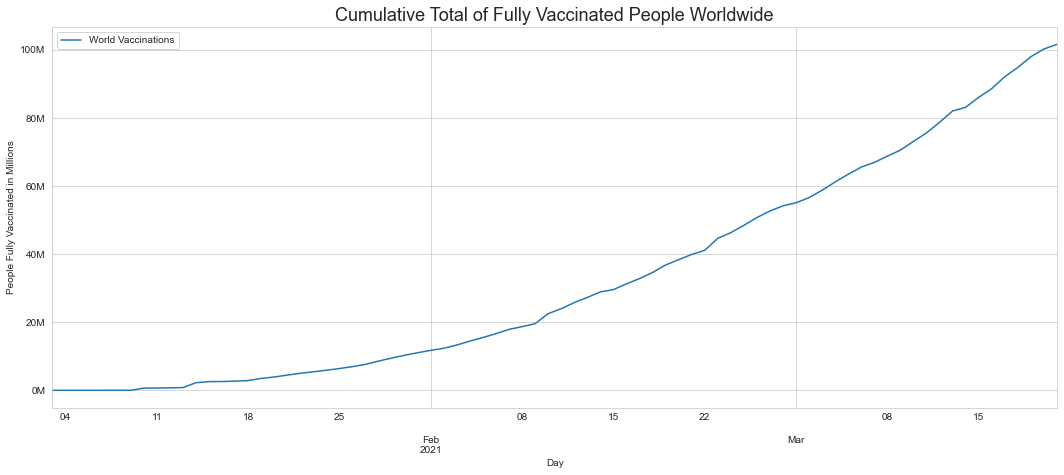

In [6]:
# Change format of y labels to millions
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.fM' % (x * 1e-6)
formatter = FuncFormatter(millions)

# plot World vaccinations
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
world_df.plot(figsize= (18, 7), ax= ax)
plt.legend(['World Vaccinations'], fancybox= True)
plt.title('Cumulative Total of Fully Vaccinated People Worldwide', fontsize= 18)
plt.ylabel('People Fully Vaccinated in Millions')
plt.show()

Our data has an upward trend and will most likely have an exponential trend as more vaccines are approved for use, especially vaccines that only require one dose instead of two.

In [172]:
fig = px.line(world_df, x= world_df.index, y= 'people_fully_vaccinated')
fig.show()

array([[<AxesSubplot:title={'center':'people_fully_vaccinated'}>]],
      dtype=object)

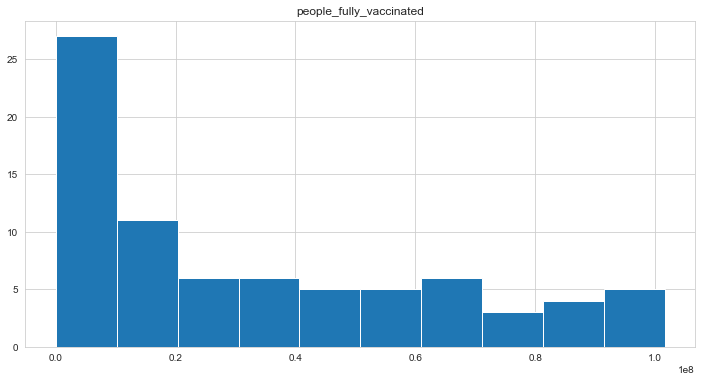

In [7]:
world_df.hist(figsize= (12,6))

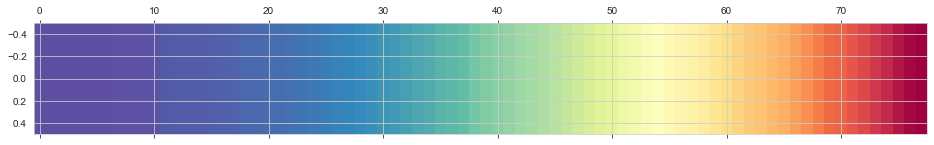

In [8]:
world_matrix = world_df.T
plt.matshow(world_matrix, interpolation= None, aspect= 'auto', cmap = plt.cm.Spectral_r);

As we would expect, the colors progress overtime.

## Remove Trends

In [9]:
# Create function to calculate Dickey Fuller test and plot rolling statistics
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

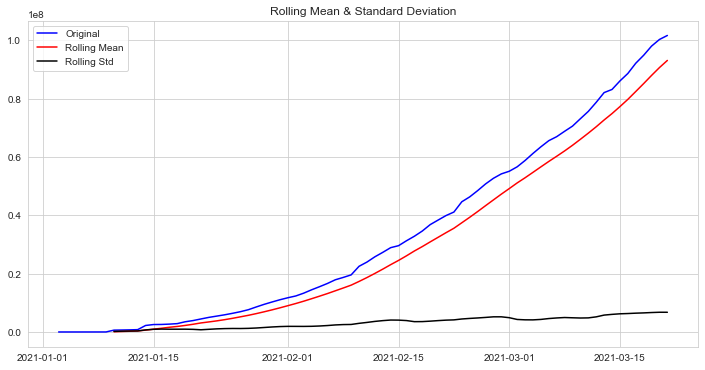

Results of Dickey-Fuller Test: 

Test Statistic                  0.835485
p-value                         0.992188
#Lags Used                      7.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [10]:
stationarity_check(world_df)

The p-value is almost 1 which means this is very much not a stationary time series.

Now we are certain there is a trend, it is time to remove it.

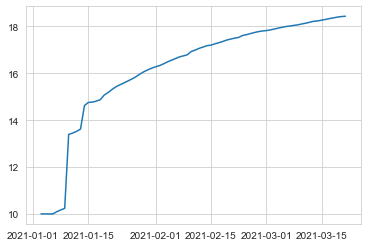

In [11]:
# Log transform data and see if that removed trend?
ts_log = np.log(world_df)
plt.plot(ts_log)

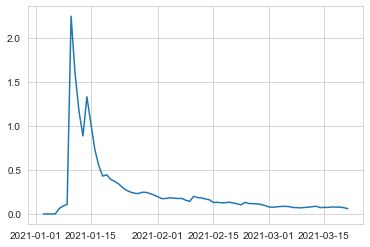

In [12]:
# Subtract the exponential weighted rolling mean with a halflife of 2
exponential_roll_mean = ts_log.ewm(halflife= 2).mean()
minus_exp_roll_mean = ts_log - exponential_roll_mean

plt.plot(minus_exp_roll_mean)

In [13]:
# Finally, use differencing to remove enough trend to get a low p-value
differencing = minus_exp_roll_mean.diff(periods= 4)
differencing.dropna(inplace= True)

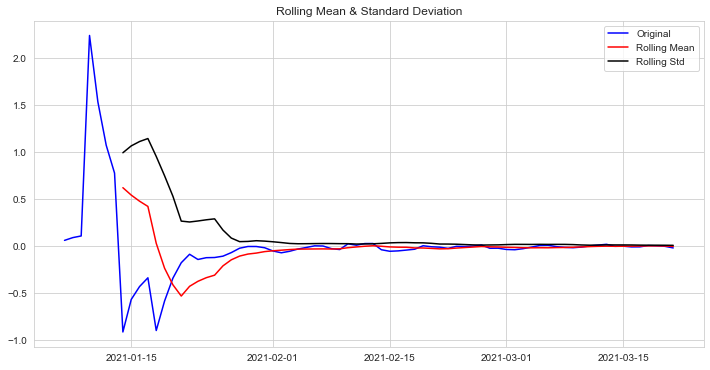

Results of Dickey-Fuller Test: 

Test Statistic                 -3.145290
p-value                         0.023378
#Lags Used                      9.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


In [14]:
# visualize data after differencing and check p-value with Dickey Fuller test
stationarity_check(differencing)

**P-Value = 0.023**  -- This is a low enough p-value to consider any trends erased and we can now use this data to model and predict.

Now let's try decomposition and see if performs better than differencing.

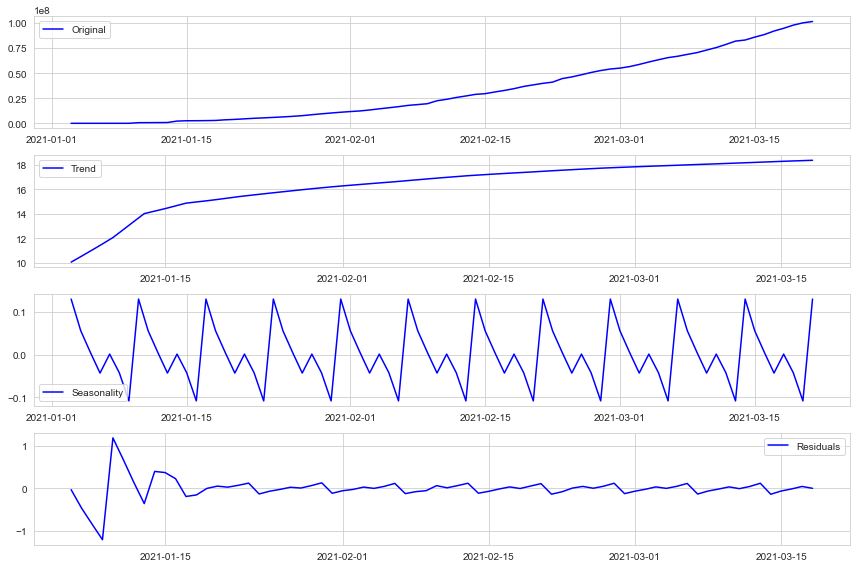

In [15]:
# calculate decomposition and separate the components
decomposition = seasonal_decompose(np.log(world_df), model= 'additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(world_df, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

Text(0.5, 1.0, 'Decomposed World Vaccination Data')

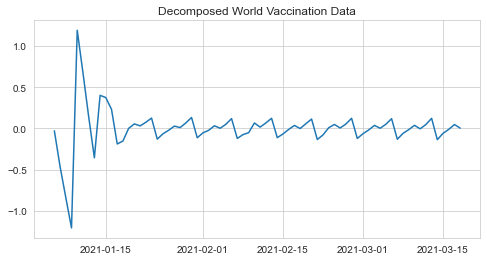

In [16]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace= True)

plt.figure(figsize= (8, 4))
plt.plot(ts_log_decompose)
plt.title('Decomposed World Vaccination Data')

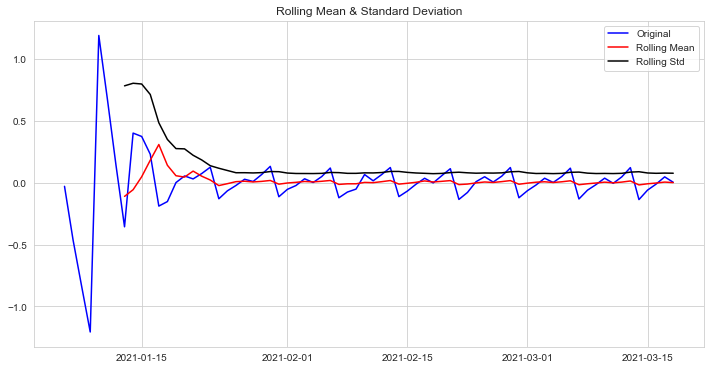

Results of Dickey-Fuller Test: 

Test Statistic                -23.282473
p-value                         0.000000
#Lags Used                     10.000000
Number of Observations Used    61.000000
Critical Value (1%)            -3.542413
Critical Value (5%)            -2.910236
Critical Value (10%)           -2.592745
dtype: float64


In [17]:
stationarity_check(ts_log_decompose)

## Time Series Forecasting
 
 ARIMA AND LSTM's

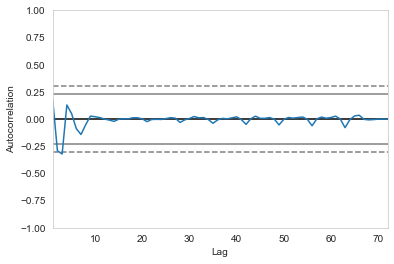

In [18]:
# use pandas autocorrelation plot to view all lags
autocorrelation_plot(ts_log_decompose)
plt.show()

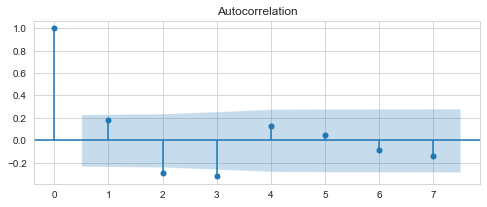

In [19]:
# plot ACF 
fig, ax = plt.subplots(figsize= (8, 3))
plot_acf(ts_log_decompose, ax= ax, lags= 7);

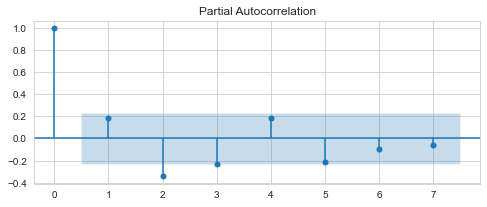

In [20]:
#plot PACF
fig, ax = plt.subplots(figsize= (8, 3))
plot_pacf(ts_log_decompose, ax= ax, lags= 7);

In [21]:
# data_diff = world_df.diff().dropna()
# data_diff

In [22]:
# arima_world = ARIMA(data_diff, order= (3, 0, 3))
# arima_world.fit()

In [23]:
arima_world = ARIMA(ts_log_decompose, order= (3, 0, 3))
arima_world.fit()

In [24]:
# arima_world.param_names

### Model using PMD ARIMA

In [25]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import ADFTest

In [26]:
adf_test = ADFTest(alpha= 0.05)

In [27]:
adf_test.should_diff(world_df)

(0.9757077521494709, True)

In [28]:
# a train/test split
train, test = train_test_split(world_df, test_size= 0.1)

In [108]:
train.shape

(70, 1)

In [30]:
test.shape

(8, 1)

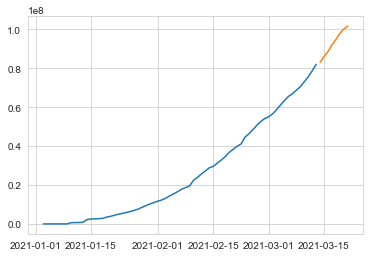

In [31]:
plt.plot(train)
plt.plot(test)

In [32]:
model = pm.auto_arima(train)

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   70
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -991.941
Date:                Sun, 28 Mar 2021   AIC                           1987.881
Time:                        15:39:32   BIC                           1992.320
Sample:                             0   HQIC                          1989.640
                                 - 70                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7019      0.134     -5.228      0.000      -0.965      -0.439
sigma2       3.05e+11   5.38e-14   5.67e+24      0.000    3.05e+11    3.05e+11
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                68.29
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               3.75   Skew:                             1.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.03e+40. Standard errors may be unstable.
"""

In [34]:
preds, conf_int = model.predict(n_periods=test.shape[0], return_conf_int=True)
print('Test RMSE: %.3f' % np.sqrt(mean_squared_error(test, preds)))

Test RMSE: 1336169.196


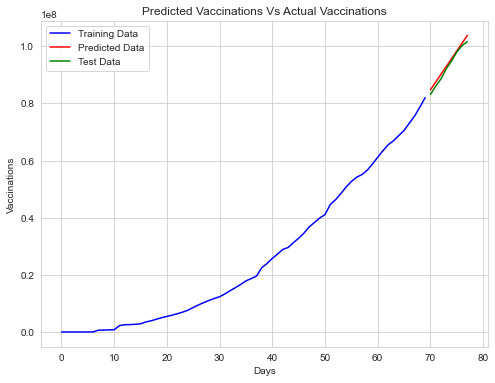

In [35]:
x = np.arange(world_df.shape[0])
plt.figure(figsize= (8, 6))
plt.plot(x[:70], train, c='blue', label= 'Training Data')
plt.plot(x[70:], preds, c='red', label= 'Predicted Data')
plt.plot(x[70:], test, c= 'green', label= 'Test Data')
plt.title('Predicted Vaccinations Vs Actual Vaccinations')
plt.xlabel('Days')
plt.ylabel('Vaccinations')
plt.legend()
plt.show()

In [36]:
next_n = model.predict(n_periods= 21)

In [37]:
next_n

array([8.47564659e+07, 8.74747658e+07, 9.01930657e+07, 9.29113656e+07,
       9.56296654e+07, 9.83479653e+07, 1.01066265e+08, 1.03784565e+08,
       1.06502865e+08, 1.09221165e+08, 1.11939465e+08, 1.14657765e+08,
       1.17376065e+08, 1.20094364e+08, 1.22812664e+08, 1.25530964e+08,
       1.28249264e+08, 1.30967564e+08, 1.33685864e+08, 1.36404164e+08,
       1.39122464e+08])

In [38]:
# Use bokeh to plot predictions
import bokeh.io

bokeh.io.reset_output()
bokeh.io.output_notebook()
from bokeh.plotting import figure, show, output_notebook
from bokeh.io import output_notebook
from bokeh.models import Legend
from bokeh.models import NumeralTickFormatter

Loading BokehJS ...

In [39]:
def plot_arima(truth, forecasts, title="ARIMA", xaxis_label='Time',
               yaxis_label='Value', c1='#A6CEE3', c2='#B2DF8A', 
               forecast_start=None, **kwargs):
    
    # make truth and forecasts into pandas series
    n_truth = truth.shape[0]
    n_forecasts = forecasts.shape[0]
    
    # always plot truth the same
    truth_idx = np.arange(truth.shape[0])
    truths = truth.loc[:, 'people_fully_vaccinated']
    
    # if no defined forecast start, start at the end
    if forecast_start is None:
        idx = np.arange(n_truth, n_truth + n_forecasts)
    else:
        idx = np.arange(forecast_start, n_forecasts)
    forecasts = pd.Series(forecasts, index=idx)
    
    # set up the plot
    p = figure(title=title, plot_height=400, **kwargs)
    p.grid.grid_line_alpha=0.3
    p.xaxis.axis_label = xaxis_label
    p.yaxis.axis_label = yaxis_label
    
    # add the lines
    p.line(truth_idx, truths.values, legend_label='Observed', 
           line_width= 3, line_color = '#0099ff')
    p.line(forecasts.index, forecasts.values, legend_label='Forecasted', 
           line_width= 3, line_color= '#ff9933')
    
    p.yaxis[0].formatter = NumeralTickFormatter(format= '0.0a')
    p.legend.location = 'bottom_right'
    
    return p

In [40]:
show(plot_arima(world_df, next_n, yaxis_label= 'Vaccinations', 
                xaxis_label = 'Days', title= 'Vaccination Predictions'))

#### Newer data:

In [41]:
fully_vax_df2 = pd.read_csv('../data/people-fully-vaccinated-covid2.csv')
fully_vax_df2['Day'] = pd.to_datetime(fully_vax_df2['Day'])

fully_vax_ts2 = fully_vax_df2.copy()
fully_vax_ts2.set_index('Day', inplace= True)

world_df2 = fully_vax_ts2.where(fully_vax_ts2['Entity'] == 'World')
world_df2.dropna(inplace= True)
world_df2.drop(['Code', 'Entity'], axis= 1, inplace= True)

In [42]:
world_df2

,people_fully_vaccinated
Day,
2021-01-03,2.200200e+04
2021-01-04,2.200400e+04
2021-01-05,2.200400e+04
2021-01-06,2.200400e+04
2021-01-07,2.418000e+04
...,...
2021-03-22,1.062202e+08
2021-03-23,1.088105e+08
2021-03-24,1.116585e+08


In [43]:
train, test = train_test_split(world_df2, test_size= 0.15)

In [44]:
print(train.shape)
test.shape

(70, 1)


(13, 1)

In [45]:
model2 = pm.auto_arima(train)

In [46]:
preds, conf_int = model2.predict(n_periods=test.shape[0], return_conf_int=True)
print('Test RMSE: %.3f' % np.sqrt(mean_squared_error(test, preds)))

Test RMSE: 986850.698


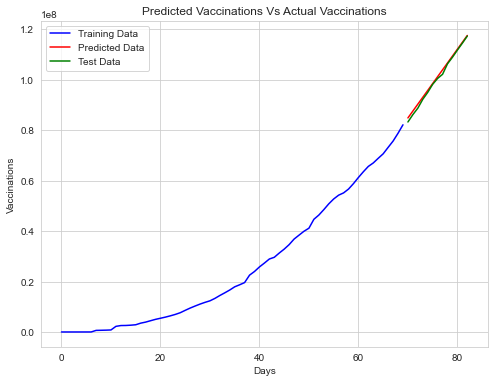

In [47]:
x = np.arange(world_df2.shape[0])
plt.figure(figsize= (8, 6))
plt.plot(x[:70], train, c='blue', label= 'Training Data')
plt.plot(x[70:], preds, c='red', label= 'Predicted Data')
plt.plot(x[70:], test, c= 'green', label= 'Test Data')
plt.title('Predicted Vaccinations Vs Actual Vaccinations')
plt.xlabel('Days')
plt.ylabel('Vaccinations')
plt.legend()
plt.show()

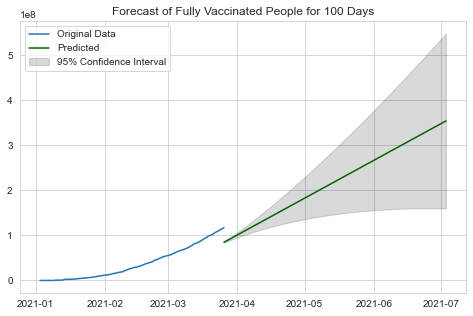

In [164]:
n_periods = 100
fitted, confint = model2.predict(n_periods= n_periods, return_conf_int= True)
index_of_fc = pd.date_range(world_df2.index[-1], periods= n_periods, freq= 'd')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

#plot figure
plt.figure(figsize= (8, 5))
plt.plot(world_df2, label= 'Original Data')
plt.plot(fitted_series, color= 'darkgreen', label= 'Predicted')
plt.fill_between(lower_series.index, lower_series, upper_series, color= 'k', 
                 alpha= 0.15, label= '95% Confidence Interval')
plt.title('Forecast of Fully Vaccinated People for 100 Days')
plt.legend(loc= 'upper left')
plt.show()

In [92]:
next_n = model2.predict(n_periods= 365)

In [93]:
show(plot_arima(world_df2, next_n, yaxis_label= 'Vaccinations', 
                xaxis_label = 'Days', title= 'Vaccination Predictions'))

### Model using statsmodels ARIMA

In [143]:
train, test = train_test_split(world_df, test_size= 0.1)

In [144]:
# should be last days of dataset
test

,people_fully_vaccinated
Day,
2021-03-14,83112641.0
2021-03-15,86026166.0
2021-03-16,88582953.0
2021-03-17,92088908.0
2021-03-18,94822964.0
2021-03-19,97965307.0
2021-03-20,100237781.0
2021-03-21,101609777.0


In [145]:
model = ARIMA(train, order= (0, 2, 1))
fitted = model.fit()
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                  
======================================================================================
Dep. Variable:     D2.people_fully_vaccinated   No. Observations:                   68
Model:                         ARIMA(0, 2, 1)   Log Likelihood                -985.801
Method:                               css-mle   S.D. of innovations         463700.724
Date:                        Sun, 28 Mar 2021   AIC                           1977.601
Time:                                17:09:38   BIC                           1984.260
Sample:                            01-05-2021   HQIC                          1980.239
                                 - 03-13-2021                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             3.803e+04   2802.854     13.569      0.000    3.25e+04    4.35e+04
ma.L1.D2.people_fully_vaccinated    -1.0000      0.042    -23.728      0.000      -1.083      -0.917
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [131]:
fc, se, conf = fitted.forecast(8, alpha= 0.05)

In [132]:
test.index

DatetimeIndex(['2021-03-18', '2021-03-19', '2021-03-20', '2021-03-21',
               '2021-03-22', '2021-03-23', '2021-03-24', '2021-03-25',
               '2021-03-26'],
              dtype='datetime64[ns]', name='Day', freq=None)

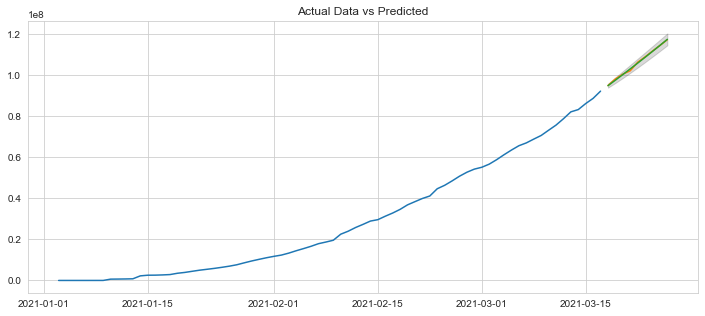

In [135]:
fc_series = pd.Series(fc, index= test.index)
lower_series = pd.Series(conf[:, 0], index= test.index)
upper_series = pd.Series(conf[:, 1], index= test.index)

# plot
plt.figure(figsize= (12, 5))
plt.plot(train, label= 'training')
plt.plot(test, label= 'test')
plt.plot(fc_series, label= 'forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color= 'k',  alpha= 0.15)
plt.title('Actual Data vs Predicted')
plt.show()

In [150]:
# calculate root mean squared error
rmse = np.mean((fc - test.values)**2)**.5 
print('RMSE: {:,.0f}'.format(rmse))

RMSE: 16,072,626


In [157]:
# calculate mean absolute percentage error
# measure of prediction accuracy of a forecasting method in statistics
mape = np.mean(np.abs(fc - test.values)/np.abs(test.values))  
print('MAPE: {:0.2f}'.format(mape*100))

MAPE: 15.01


This model is about 85% accurate in predicting the next 8 days and predictions are about 16M off. Not too bad when we are looking at 100's of millions of people.

#### Build model with whole dataset

In [139]:
# build and fit ARIMA model with whole dataset
# use p, d, q from auto_arima
model = ARIMA(world_df, order= (0, 2, 1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARIMA Model Results                                  
======================================================================================
Dep. Variable:     D2.people_fully_vaccinated   No. Observations:                   76
Model:                         ARIMA(0, 2, 1)   Log Likelihood               -1109.047
Method:                               css-mle   S.D. of innovations         511556.412
Date:                        Sun, 28 Mar 2021   AIC                           2224.095
Time:                                17:08:51   BIC                           2231.087
Sample:                            01-05-2021   HQIC                          2226.889
                                 - 03-21-2021                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                             3.655e+04   2622.938     13.934      0.000    3.14e+04    4.17e+04
ma.L1.D2.people_fully_vaccinated    -1.0000      0.037    -27.283      0.000      -1.072      -0.928
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

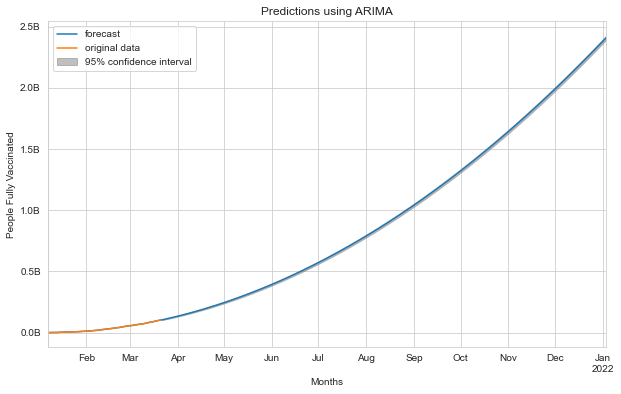

In [111]:
# Change format of y labels to billions
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fB' % (x * 1e-9)
formatter = FuncFormatter(billions)

fig, ax = plt.subplots(figsize= (10,6))
ax.yaxis.set_major_formatter(formatter)
results.plot_predict(4, 365, ax= ax)

plt.title('Predictions using ARIMA')
plt.xlabel('Months')
plt.ylabel('People Fully Vaccinated')
plt.legend(labels= ['forecast', 'original data', '95% confidence interval'])

In [103]:
# calculate number of people that need to be vaccinated worldwide 
# to reach herd immunity

world_pop = 7874965825

#26% of population under 16 yrs old
pop_under_16 = .26
w_pop_over16 = world_pop * (1 - pop_under_16)   
print('Population over 16 years old: {:,.0f}'.format(w_pop_over16))

herd_immunity = .7
pop_need_fully_vax = w_pop_over16 * herd_immunity
print('Population that needs to be vaccinated for herd immunity: {:,.0f}'\
      .format(pop_need_fully_vax) )

Population over 16 years old: 5,827,474,710
Population that needs to be vaccinated for herd immunity: 4,079,232,297


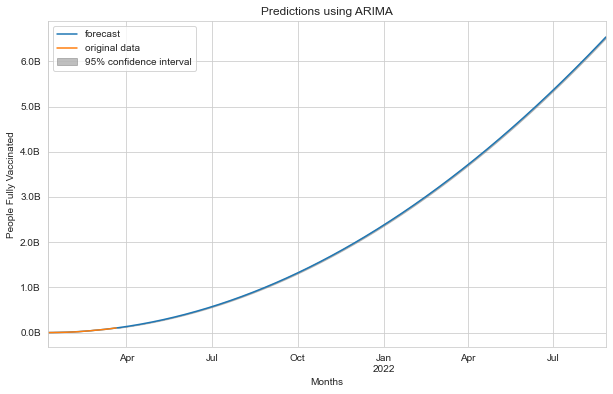

In [104]:
# Change format of y labels to billions
def billions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fB' % (x * 1e-9)
formatter = FuncFormatter(billions)

fig, ax = plt.subplots(figsize= (10,6))
ax.yaxis.set_major_formatter(formatter)
results.plot_predict(4, 600, ax= ax)

plt.title('Predictions using ARIMA')
plt.xlabel('Months')
plt.ylabel('People Fully Vaccinated')
plt.legend(labels= ['forecast', 'original data', '95% confidence interval'])

According to our calculations, over 4 billion people would need to be vaccinated to equal worldwide herd immunity. The projection shows that could be somewhere around May 2022 if the vaccinations continue on the same trajectory.

In [159]:
model.plot_diagnostics(figsize =(8, 5))

AttributeError: 'ARIMA' object has no attribute 'plot_diagnostics'

### Single Exponential Smoothing

Because the model does not have any seasonality (there barely has even been one season within this data), I will try using single exponential smoothing, or SES.

In [59]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ModuleNotFoundError: No module named 'statsmodels.tsa.arima_model.ARMAResults'; 'statsmodels.tsa.arima_model' is not a package

In [51]:
model_SES = SimpleExpSmoothing(world_df2)

In [52]:
model3 = model_SES.fit(optimized= True, smoothing_level = 0.2)

In [60]:
preds = model3.predict()

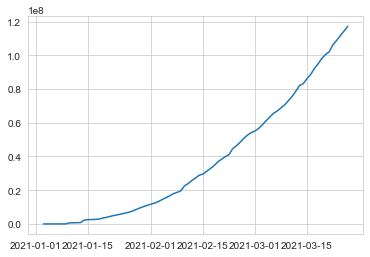

In [54]:
plt.plot(world_df2)

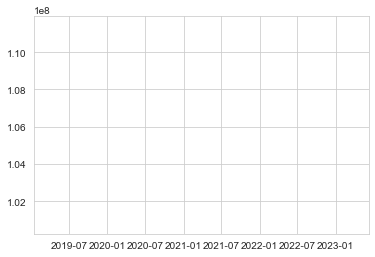

In [55]:
plt.plot(preds)

Weighted Moving Averages 

Place more weight on most recent values, less weight on older values

### LSTM

In [175]:
# split test data into test and validation
validation = test[:4]
test = test[4:]

In [179]:
# scale the data
scaler = StandardScaler()
train_arr = scaler.fit_transform(train)
val_arr = scaler.transform(validation)
test_arr = scaler.transform(test)

In [183]:
from sklearn.preprocessing import MinMaxScaler
min_scaler = MinMaxScaler()

scaled_train = min_scaler.fit_transform(train)
scaled_val = min_scaler.transform(validation)
scaled_test = min_scaler.transform(test)

In [191]:
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
generator = TimeseriesGenerator(scaled_train, scaled_train, length=)

### Caveats:
- removing people under 16 from population, but different regions will have different ratio of minors and adults [see here](https://www.statista.com/statistics/265759/world-population-by-age-and-region/)
- fully vaccinated means person has received 2 shots. New vaccines are emerging that only require one shot, and will through off the prediction
- different parts of the world are vaccinating at different rates. There will be some countries that will reach 70% vaccinated before others



### Extras, Notes:

In [56]:
asdfasdfasdf

NameError: name 'asdfasdfasdf' is not defined

In [ ]:
day_groups = world_df.groupby(pd.Grouper(freq= 'D'))

daily_vax = pd.concat([pd.DataFrame(x[1].values) for x in day_groups], axis= 1)
daily_df = pd.DataFrame(daily_vax)

In [ ]:
daily_df.boxplot(figsize= (15, 10))

### Model using Forecast function

In [ ]:
len(world_df)

In [ ]:
# pip install --upgrade ipykernel

In [ ]:
split_point = len(world_df) - 5
data, validation = world_df[0:split_point], world_df[split_point:]
print('Data %d, Validation %d' % (len(data), len(validation)))

In [ ]:
X = differencing.values
X

In [ ]:
model = ARIMA(X, order= (2, 0, 1))

In [ ]:
model_fit = model.fit()
model_fit.summary()

In [ ]:
prediction = model_fit.predict(start= 60, end= 73, dynamic= True)

In [ ]:
plt.plot(prediction)

In [ ]:
forecast = model_fit.forecast(steps= 21)[0]

In [ ]:
forecast

In [ ]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [ ]:
history = [x for x in X]
days = 60
day = 1
for yhat in forecast:
    inverted = inverse_difference(history, yhat, days)
    print('Day %d: %f' % (day, inverted))
    history.append(inverted)
    day +=1

In [ ]:
plt.plot(forecast)
plt.show()
